# Identify the candidate blooming bacteria

The goal of this notebook is to identify candidate bacteria which bloom under shipping conditions. We identified cadnidates in two parts: first, we looked for bacteria which grew at room temperature in storage studies. We also looked at shipped American Gut samples and compared them to fresh frozen fecal samples. We used the combined technique because the storage studies were limited by size, while the comparison between studies is noisy.

Briefly, this process will involve the following steps:

1. Load the datasets (Mayo and Se-Jin storage studies and AG, PGP, UK-Twins and Whole grain feces)
2. Calculate the fold change per sOTU in the storage studies
3. Calculate the fold change in AG compared to fresh frozen studies (PGP, UK-Twins and Whole grain feces)
4. Identify candidate blooming bacteria by combining the fold changes in 2,3
5. Plot the scatter of the fold change per sOTU with highlighting the candidate blooming bacteria
6. Plot taxonomy plots before and after bloom filtering

Let's start by loading the necessary python functions. 

In [1]:
import hashlib

import matplotlib as mpl
mpl.use('Agg')

# load modules used in the analysis
import biom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import skbio
from skbio.stats.composition import closure

from bloom.stats import ancom

# plots inside the notebook
%matplotlib notebook

# set the random seed
np.random.seed(2016)

/Users/jdebelius/miniconda2/envs/bloom/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import pandas as pd
import numpy as np

def exploding_panda(_bt):
    """BIOM->Pandas dataframe converter

    Parameters
    ----------
    _bt : biom.Table
        BIOM table

    Returns
    -------
    pandas.DataFrame
        The BIOM table converted into a DataFrame
        object.

    References
    ----------
    Based on this answer on SO:
    http://stackoverflow.com/a/17819427/379593
    """
    m = _bt.matrix_data
    data = [pd.SparseSeries(m[i].toarray().ravel()) for i in np.arange(m.shape[0])]
    out = pd.SparseDataFrame(data, index=_bt.ids('observation'),
                             columns=_bt.ids('sample'))

    return out

# Loading all experimental data

We'll write a quick function to load the data. We'll load the biom table (`biom_fp`). We'll load the specified metadata columns (`meta_fp` and `keep_columns`). Then, we'll filter the data to include only samples with at least 1000 counts/sample (`depth`) and that fit the filtering criteria (`filters`). Finally, we'll add information about the study and preservation method to make later analysis easier.

In [3]:
def load_studies(biom_fp, meta_fp, name, preservation, keep_columns=None, 
                 filters={}, depth=1000):
    """Loads the studies more easily"""
    # Loads the mapping file
    if keep_columns == None:
        meta = pd.read_csv(meta_fp, sep='\t', dtype=str)
    else:
        meta = pd.read_csv(meta_fp, sep='\t', dtype=str, usecols=keep_columns)
    meta.set_index('#SampleID', inplace=True)
    
    # Loads the biom table
    sotu = biom.load_table(biom_fp)

    # We'll first filter the table by sequencing depth
    sotu = sotu.filter(lambda val, id_, md: val.sum() > depth, axis='sample')
    meta = meta.loc[sotu.ids(axis='sample')]
    
    # Filters the samples
    def filter_meta(x):
        return np.all([x[k] == v for k, v in filters.items()])
    
    meta_f = meta.loc[meta.apply(filter_meta, axis=1)].copy()
    meta_f['STUDY'] = name
    meta_f['PRESERVATION'] = preservation
    sotu_f = sotu.filter(meta_f.index)
    
    return meta_f, sotu_f

## Song fecal stability study

The Song fecal stability study [[1](#1)] compares the stability of human and dog fecal samples under a variety of storage conditions.

We will only use samples with no preservative stored at ambient temperature for 7, 14 and 28 days (compared to samples sequenced at day 0).

In [4]:
song_meta, song_sotu = load_studies(
    biom_fp = '../data/storage.sejin.clean.withtax.biom',
    meta_fp = '../data/map.storage.sejin.txt',
    name='SONG',
    preservation='STORAGE',
    keep_columns=['#SampleID', 'preservative', 'temperature', 'temp2', 'species', 
                  'time_numeric', 'subject'],
    filters={'preservative': 'None',
             'temperature': 'amb',
             'species': 'human'},
    )

The sample is filtered to only include perservative-free samples stored at room temperature. These include samples collected at day 0 and immediately sequenced, which we use as a reference. We will only use samples with at least 1000 sequences.

## Mayo fecal stability study

The Mayo fecal stability study [[2](#2)] compares the effect of different storage conditions on human fecal samples. Samples were stored at room temperature with or without perservatives. We'll only look at samples without perservative.

In [5]:
mayo_meta, mayo_sotu = load_studies(
    biom_fp = '../data/mayo.new.min10.clean.withtax.biom',
    meta_fp = '../data/map.mayo1.txt',
    name='MAYO_STORAGE',
    preservation='STORAGE',
    filters={'TREATMENT': 'No Additive'},
    )

## American Gut

The [American Gut Project](<http://www.americangut.org>) is a cross sectional study. Samples were shipped through local post without perservatives. We will use only fecal samples with at least 1000 sequences per sample.

In [6]:
agp_meta, agp_sotu = load_studies(biom_fp='../data/ag.qiita-10317.biom',
                                  meta_fp='../data/ag.qiita-10317.txt',
                                  name='AGP',
                                  preservation='NONE',
                                  keep_columns=['BODY_HABITAT', '#SampleID'],
                                  filters={'BODY_HABITAT': 'UBERON:feces'}
                                  )

## UK twins study

We'll use data from Goodrich et al [[3](#3)], a fresh frozen study comparing the heritability of the microbiome in monozygotic and dizygotic twins.

In [7]:
twin_meta, twin_sotu = load_studies(biom_fp='../data/twins.qiita-2014.biom',
                                meta_fp='../data/twins.qiita-2014.txt',
                                name='UK_TWINS',
                                preservation='FRESH_FROZEN',
                                keep_columns=['env_matter', '#SampleID'],
                                filters={'env_matter': 'ENVO:feces'}
                                )

## PGP

(unpublished), Qiita study ID [1189](<https://qiita.ucsd.edu/study/description/1189>)

Samples were collected from participants in the Personal Genome Project and fresh frozen. The study has not yet been published, but data is avaliable in [Qiita study 1189](<https://qiita.ucsd.edu/study/description/1189>). The study contains fecal, oral and skin samples. We'll use only the fecal samples.


In [8]:
pgp_meta, pgp_sotu = load_studies(biom_fp='../data/pgp.qiita-1189.biom',
                                  meta_fp='../data/pgp.qiita-1189.txt',
                                  name='PGP',
                                  preservation='FRESH_FROZEN',
                                  keep_columns=['#SampleID', 'body_product'],
                                  filters={'body_product': 'UBERON:feces'}
                                  )

## Ercolini whole grain feces

This study [[4](#4)] contains fecal samples from 80 healthy overweight/obese subjects, part of which undergoing whole grain wheat dietery intervention.

In [9]:
erc_meta, erc_sotu = load_studies(biom_fp='../data/erc.qiita-1481.biom',
                                  meta_fp='../data/erc.qiita-1481.txt',
                                  name='ERC',
                                  preservation='FRESH_FROZEN',
                                  keep_columns=['env_matter', '#SampleID'],
                                  filters={'env_matter': 'ENVO:feces'}
                                  )

# Analysis

## Calculate growth for bacteria in storage studies
For each sOTU, calculate the mean fold change over all individuals, using a minimal read cutoff of 5 reads/sample to reduce effect of discretization and multinomial sampling of low frequency sOTUs.

Let's start by defining the function we'll use to calculate these fold differences. We'll take a map and subOTU table for a storage study. We assume that this study includes multiple samples from the same individual (designated by the `subject` column). We can compare the difference between timepoints (identied as the values of `time0` and `time1` and found in the `time_col`). Additional filters to select the sames, such as the perservative or storage temperature can be specified as well, using `filters`. The minimum sequencing depth for a sample to be considered is set as `seq_depth`, while the minimum number of counts for an OTU to be compared is `min_count`.

The function will calculate the mean fold change in sOTUs of interest between the two time points for all OTUs which have at least hte minimum number of counts either before or after storage.

In [10]:
def test_stability(map_, otu_, time_col='time_numeric', time0='1', time1='2', 
                   subject_col='subject', mincount=5, seq_depth=2500, filters={}):
    """Calculates the fold change in a sub OTU between timepoints
    
    Parameters
    ----------
    map_ : DataFrame
        The mapping file for the study. Must contain the columns
    """
    # Filters out samples without at least the minimum number of sequences
    
    
    # Filters out sOTUs without at least 0 sequences/sample
    
    # Sets up a filter for the mapping file to get the appropriate data.
    def stability_filter(x):
        return ((x[time_col] in {time0, time1}) &
                (np.all([x[c] == v for c, v in filters.items()]))
                )
    
    # Filters the mapping file and otu table
    map_ = map_.loc[map_.apply(stability_filter, axis=1)].copy()
    otu_ = otu_.filter(map_.index, inplace=False)
    otu_ = otu_.filter(lambda val, id_, md: (val.sum() > 0), axis='observation')
    
    otu_ids = otu_.ids('observation')
    ratios = []
    subjects = []
    # Groups by subject and iterates through the comparison
    for hsi, sub_map in map_.groupby(subject_col):
        # Gets the list of samples at each time point
        id0 = set(sub_map.index[sub_map[time_col] == time0])
        id1 = set(sub_map.index[sub_map[time_col] == time1])
        
        # If there aren't samples for each timepoint, continue
        if ((len(id0) == 0) or (len(id1) == 0)):
            continue
        
        # Gets the OTU data
        sotus0 = otu_.filter(id0, inplace=False).sum(axis='observation') / len(id0)
        sotus1 = otu_.filter(id1, inplace=False).sum(axis='observation') / len(id1)

        low = (sotus0 < mincount) & (sotus1 < mincount)

        sotus0[sotus0 < mincount] = mincount
        sotus1[sotus1 < mincount] = mincount

        ratio = sotus1 / sotus0
        ratio[low] = np.nan
        ratios.append(ratio)
        subjects.append(hsi)
    
    # Gets the list of ratios exlcuding any otu which doesnt meet the filtering criteria
    ratios = pd.DataFrame(np.vstack(ratios), index=subjects, columns=otu_ids)
    ratios.dropna(1, inplace=True, how='all')

    # Calculate the mean fold change and the log fold change
    fc = pd.Series(np.nanmean(ratios, 0), index=ratios.columns)
    
    return fc

We'll also generate a pretty histogram plot showing the comparison. This will take the fold change values and return a maplotlib axis with a plot. 

In [11]:
def plot_logfoldchange_histogram(foldchange, fig=None, ax=None):
    """Makes a pretty histogram of the fold change"""
    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = plt.axes()
    # Constant limits and bins facilitate comparisons
    sn.distplot(np.log2(foldchange.dropna()), ax=ax, bins=np.linspace(-12, 12, 120))
    ax.set_xlim([-12, 12])
    ax.set_ylim([0, 1])
    # Sets up axis labels
    ax.set_ylabel('Number of OTUs', size=24)
    ax.set_xlabel('log$_{2}$(fold change)', size=24)
    ax.tick_params(axis='both', which='major', labelsize=24)
    plt.tight_layout()
    
    return fig

We'll look at the fold change in the mayo stability study. We'll compare the samples from day 0 to day 1 and day 4.

In [12]:
mayo_fc  = pd.DataFrame(
    data=[test_stability(mayo_meta, mayo_sotu, 
                         time_col='SAMPLE_VISIT', 
                         subject_col='HOST_SUBJECT_ID',
                         time0='Day 0', 
                         time1 = 'Day %i' % day) for day in [1, 4]],
    index=['Day 1', 'Day 4']
    ).T

Let's also look at the change between day 0 and day 1 in the same study.

We'll also look at the Song stability study, comparing fresh samples to those stored for one, two, and seven weeks.

In [13]:
song_fc  = pd.DataFrame(
    data=[test_stability(song_meta, song_sotu, 
                         time0='1', 
                         time1 = '%i' % day) for day in [2, 3, 4]],
    index=['Week 1', 'Week 2', 'Week 7']
    ).T

## Differential Expression
We'll next look at how American Gut, the shipped study, looks in comparison to the fresh frozen studies.

So, we'll join all the cross sectional studies together and find sOTUs which differ significantly.
Join all studies together and find sOTUs sginificantly higher/lower in AG

In [14]:
# Combines the metadata
fec_meta = pd.concat([pgp_meta[['STUDY', 'PRESERVATION']], 
                      twin_meta[['STUDY', 'PRESERVATION']], 
                      agp_meta[['STUDY', 'PRESERVATION']], 
                      erc_meta[['STUDY', 'PRESERVATION']]])

In [15]:
# Combines the sOTU tables
fec_sotu = pgp_sotu.merge(twin_sotu).merge(agp_sotu).merge(erc_sotu)

# ------- REMOVE THESE CELLS --------

In [16]:
keep_ids = np.hstack(
    [np.random.choice(fec_meta.loc[fec_meta['STUDY'] == study].index, 25, replace=False)
     for study in fec_meta['STUDY'].unique()]
    )
fec_meta = fec_meta.loc[keep_ids].copy()
fec_sotu = fec_sotu.filter(keep_ids, axis='sample')

# -------------------------------------------

Once we combine the studies, we'll filter out any OTU present in less than 

In [17]:
fec_sotu = fec_sotu.filter(lambda val, id_, md: val.sum() > 50, axis='observation', inplace=False)

We'll use ANCOM [[5](#5)] to analyze the differential abundance between the fresh frozen and unpreserved studies, and then use this to calculate a fold change. We'll start by casting our sOTU tables to a dataframe, which will give us some more flexibility for the operations we need to do.

In [18]:
fec_sotu = exploding_panda(fec_sotu).to_dense()

To make handling the data easier, we'll build an MD5 look up for the sequences, and then adjust the index to account for this.

In [19]:
def hash_sequence_ids(sequences):
    sequences['md5'] = sequences['sequence'].apply(
        lambda x: hashlib.md5(x.encode('utf-8')).hexdigest()
    )
    assert len(sequences['md5'].unique()) == len(sequences['md5'])
    
    return sequences

In [20]:
fec_sotu.reset_index(inplace=True)
sequences = fec_sotu[['index']].copy()
sequences.rename(columns={'index': 'sequence'}, inplace=True)
freeze_thaw = hash_sequence_ids(sequences)

Finally, we'll replace the keyname.

In [21]:
md_key = freeze_thaw.set_index('sequence').to_dict()

In [22]:
# fec_sotu['index'] = fec_sotu['index'].apply(lambda x: md_key['md5'][x])
fec_sotu.set_index('index', inplace=True)

In [23]:
fec_sotu = fec_sotu.T

ANCOM calcuates a significant difference in the ratio abundance between sOTUs, which accounts for compositionality in the data using log ratios. The method does not accept zeros, so we're going to add a constant value of 1 to all our counts before we normalize the data.

In [24]:
fec_close = pd.DataFrame(closure(fec_sotu.values + 1),
                         index=fec_sotu.index,
                         columns=fec_sotu.columns)

Finally, let's run ANCOM and calculate the fold change.

In [53]:
%%time
ancom_stats = ancom(fec_close, 
                    fec_meta['PRESERVATION'], 
                    multiple_comparisons_correction='holm-bonferroni',
                    significance_test='permutative-anova',
                    )

/Users/jdebelius/Repositories/bloom-analyses/bloom/stats/permutation.py:169: RuntimeWarning: invalid value encountered in true_divide
  f_stat = (sstrt / dftrt) / (sserr / dferr)
/Users/jdebelius/Repositories/bloom-analyses/bloom/stats/permutation.py:171: RuntimeWarning: invalid value encountered in greater_equal
  cmps = f_stat[:, 1:].T >= f_stat[:, 0]


CPU times: user 6min 33s, sys: 22.9 s, total: 6min 56s
Wall time: 2min 31s


In [54]:
ancom_stats

,W,reject
index,,
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGTGAGACAAGTCTGAAGTGAAAATCCGGGGCTTAACCCCGGAACTGCTTTGGAAACTGCCTGACTAGAGTACAGGAGAGGTAAGTGGAATTCCTAG,0,False
TACGTAGGGAGCGAGCGTTATCCGGATTTATTGGGTGTAAAGGGTGCGTAGACGGGAAGTCAAGTTAGTTGTGAAATCCCTCGGCTTAACTGAGGAACTGCAACTAAAACTGATTTTCTTGAGTACTGGAGAGGAAAGTGGAATTCCTAG,0,False
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGATTATTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGTAGTCTTGAGTGCAGCAGAGGTAGGCGGAATTCGTGG,0,False
AACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGAAGGACAAGTTGGAAGTGAAACCCACGGGCTCAACCCGTGAACTGCTTTCAAAACTGTTTTTCTTGAGTGGTGTAGAGGTAGGCGGAATTCCCGG,0,False
TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCGGCGGCGTAAGTCAGTTGTGAAATCGTGCGGCTTAACCGTGCAATTGCAGTTGATACTGCGTCGCTTGAGTGCACACAGGGATGTTGGAATTCATGG,0,False
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAAGGCAAGTCAGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTTGAAACTGTCTAGCTAGAGTGCAGGAGAGGTAAGCGGAATTCCTAG,0,False
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGCAGCCGGGTCTGCAAGTCAGATGTGAAATCCATGGGCTCAACCCATGAACTGCATTTGAAACTGTAGATCTTGAGTGTCGGAGGGGCAATCGGAATTCCTAG,0,False
TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGATGCCAAGTCAGCTGTGAAAACTATGGGCTTAACTTGTAGACTGCAGTTGAAACTGGTATTCTTGAGTGAAGTAGAGGTTGGCGGAATTCCGAG,0,False
TACGGAGGATGCGAGCGTTATCCGGAATTATTGGGTTTAAAGGGTGCGTAGGTTGCAAGGGAAGTCAGGGGTGAAAAGCTATAGCTCAACTATGGTCTTGCCTTTGAAACTCTCTAGCTAGAGTGTACTGGAGGTACGTGGAACGTGTGG,0,False


## Calculate the fold change of american gut compared to all other experiments
For each sOTU, comapre the mean in all AG samples to the mean of all samples in a fresh-frozen experiment. The samples are unpaired, so we can't just compare the means. We'll perform this calculation seperately between each pair of studies.

We'll start by getting the pandas dataframes for each study to make the comparisons.

In [28]:
pgp_meta_f = fec_meta.loc[fec_meta['STUDY'] == 'PGP']
pgp_sotu_f = fec_sotu.loc[pgp_meta_f.index]

In [29]:
agp_meta_f = fec_meta.loc[fec_meta['STUDY'] == 'AGP']
agp_sotu_f = fec_sotu.loc[agp_meta_f.index]

In [30]:
twin_meta_f = fec_meta.loc[fec_meta['STUDY'] == 'UK_TWINS']
twin_sotu_f = fec_sotu.loc[twin_meta_f.index]

In [31]:
erc_meta_f = fec_meta.loc[fec_meta['STUDY'] == 'ERC']
erc_sotu_f = fec_sotu.loc[erc_meta_f.index]

Next, let's write a function to calculate the fold change between studies.

**Check the mask**

In [32]:
def calculate_fold_change(sotu1, sotu2, minreads=1):
    """Calculates the fold change between two datasets"""
    
    # The fold change
    fc = {}
    not_compared = []
    
    # Replaces values below the threshhold
    sotu1[sotu1 < minreads] = minreads
    sotu2[sotu2 < minreads] = minreads
    
    # Calculates the mean ratio
    ratio = sotu1.mean(0) / sotu2.mean(0)
    return ratio

And, let's calculate the fold change ratio for all combinations.

In [33]:
fold_change = pd.DataFrame([calculate_fold_change(agp_sotu_f, study)
                            for study in [pgp_sotu_f, erc_sotu_f, twin_sotu_f]],
              index=['agp_pgp', 'agp_erc', 'agp_twins']).T

In [34]:
min_ag_fc = fold_change.min(axis=1)

# find the blooming bacteria list
intersect the ag-vs-others and the storage studies fold changes:

Iterate over all sOTUs which are significantly different between AG and all fresh-frozen samples.

For each such sOTU, we calculate two values:
1. The maximal growth potential (maximum over all storage studies and days)
2. The minimal ratio between AG to each fresh-frozen sample. The minimum is taken in order to reduce the effect of study-study differences (since a blooming bacteria is expected to be higher in AG compared to all fresh-frozen studies)

Candidate blooming bacteria are defined as sOTUs that have either:
- At least two fold difference in both (1) and (2), or that are not

OR
- At least two fold difference in (2) and are not present in (1) (since storage studies have a small set of individuals, there may be blooming bacteria that by chance were not present in the storage study samples)

OR
- At least 50 fold change in (1), so we know they can grow drastically in room temp.


## Combining the stability studies

We're going to find the maximum fold difference for all comparisons based on storage studies.

However, since the song study was run on a ***Check the sequencing platform***, it has 125 nucleotide reads instead of the 150 nucelotides found in other studies. To address this, we're going to compare the first 125 nucleotides of each of the sequences in the Mayo fecal stability study to value in the song study, whther the first 125 sequences are unique or not.

We'll then build a hash based on the full 150 nucleotides, which will be the id we combine with the other study.

In [35]:
song_fc.reset_index(inplace=True)
song_fc.rename(columns={'index': 'sequence'}, inplace=True)
song_fc['sequence125'] = song_fc['sequence'].copy()
song_fc.set_index('sequence125', inplace=True)
song_fc.rename(columns={'sequence': 'song_sequence'}, inplace=True)

In [36]:
mayo_fc.reset_index(inplace=True)
mayo_fc.rename(columns={'index': 'sequence'}, inplace=True)
mayo_fc['sequence125'] = mayo_fc['sequence'].apply(lambda x: x[:124])
mayo_fc.set_index('sequence125', inplace=True)
mayo_fc.rename(columns={'sequence': 'mayo_sequence'}, inplace=True)

Now, we can combine the studies, and then combine the sequences.

In [37]:
storage_fc = song_fc.join(mayo_fc)

In [38]:
def prioritize_sequences(x):
    if pd.isnull(x['mayo_sequence']):
        return x['song_sequence']
    else:
        return x['mayo_sequence']

In [39]:
lookup_map = storage_fc[['song_sequence', 'mayo_sequence']].copy()
lookup_map['sequence'] = lookup_map.apply(prioritize_sequences, axis=1)

In [40]:
storage_lookup = hash_sequence_ids(lookup_map)
storage_fc['md5'] = storage_lookup['md5']
storage_fc.set_index('md5', inplace=True)
storage_lookup.set_index('md5', inplace=True)

Now, we can calculate the fold change between the sequences.

In [41]:
storage_max = storage_fc[['Week 1', 'Week 2', 'Week 7', 'Day 1', 'Day 4']].mean(axis=1)

In [42]:
extremes = pd.DataFrame([storage_max, min_ag_fc], 
                        index=['storage', 'freeze_thaw']).T
# extremes = extremes.loc[ancom_stats.index[ancom_stats['Reject null hypothesis']]]
extremes['score'] = extremes['storage'] + 0.01 * extremes['freeze_thaw']

In [43]:
def identify_blooms(x):
    return (((x['storage'] > 2) & (x['freeze_thaw'] > 2)) | 
            (x['storage'] > 50) |
            ((x['freeze_thaw'] > 2) & (np.isnan(x['storage'])))
            )

In [44]:
blooms = extremes.index[extremes.apply(identify_blooms, axis=1)]

In [45]:
blooms

Index(['04195686f2b70585790ec75320de0d6f', '07f3fc2191965d82f9031b119d19cb7f',
       '2b1629a873e97e24f482743105fe549c', '41f1c6e4d1e4cc653df22555bfab5796',
       '95f0cac7cb67191beab572915835222e',
       'AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAAACCATGGGCTCAACCCATGAATTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGATGGAATTCCCGG',
       'AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAGAATAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG',
       'AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGCGATCAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGATTGTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG',
       'CACGTAAGGTGCGAGCGTTATTCGGAATTATTGGGCGTAAAGGGCACGCAGGCGGCTTTGCAAGCTTGGTGTGAAATCTCAGGGCTCAACCCTGAAACTGCATTGAGAACTGCATGGCTAGAGTTAGTGAGGGGAAACCGGAATTCCAGG',
       'TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTTGAAACTGGCAGGCTTGAGTCTTGTAGAGGGGGGTAGAATTCC

# Plot the fold change scatter plot KDE with highlighting the candidate blooming sOTUs
since we have a lot of sOTUs, each with max(storage fc) and min(ag-fresh fc), we plot the average densities of all sOTUs.

Red circles denote the sOTUs (15) passing the criteria for candidate blooming bacteria. Note that an additional set of 6 candidate blooming bacteria are not shown as they do not appear in the storage studies, and therefore do not have an x coordinate on the plot.

In [46]:
clean_extremes = np.log2(extremes).dropna()

<IPython.core.display.Javascript object>


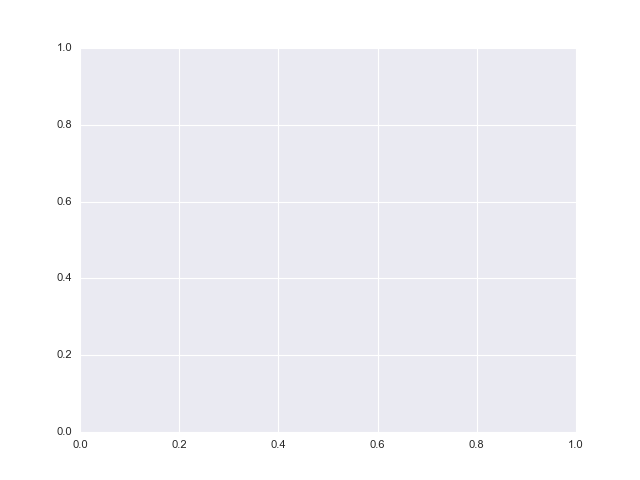

ValueError: `dataset` input should have multiple elements.

In [47]:
ax = plt.axes()
fig = ax.figure
sn.kdeplot(clean_extremes['storage'],
           clean_extremes['freeze_thaw'],
           shade=True,
           cmap='Greys',
           ax=ax)
ax.scatter(clean_extremes.loc[blooms, 'storage'],
           clean_extremes.loc[blooms, 'freeze_thaw'],
           s=80, color=sn.color_palette()[2])
# ax.set_xlim([-2, 10])
# ax.set_ylim([-5, 6])
ax.set_xlabel('max. storage study foldchange (log2)',fontsize=16)
ax.set_ylabel('min. AG foldchange (log2)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

In [178]:
plt.savefig('../results/fig1-blooming-identification-kde.pdf')

## Sort the candidate blooming sOTUs by their storage study fold change
We want to order the candidate blooming sOTUs so the more likely/larger effect size bloomers are first.

We base the sort order on the storage study maximal fold change, as this approximates the potential for blooming, and the max over different storage times shows the growth in the more optimal conditions for each candidate bloomer (whereas the AG-fresh frozen fold change shows the mean blooming). This way, we give higher priority to sOTUs that can distort the most the frequencies (even if in a small number of samples).

In [ ]:
# sort the blooming bacteria according to the maximal storage study fold change
sv,si=hs.isort(bloomscores,reverse=True)
newbloom=hs.reorder(newbloom,si)
bloomtax=hs.reorder(bloomtax,si)
bloomscores=hs.reorder(bloomscores,si)

In [ ]:
# the sorted list of blooming bacteria
for idx,ctax in enumerate(bloomtax):
    print('%d : %f %s' % (idx,bloomscores[idx],ctax))

## save the bloom sequences

In [ ]:
hs.saveseqsfasta(agf,newbloom,'../data/newbloom.all.fa')

In [ ]:
hs.saveseqsfasta(agf,newbloom[:8],'../data/newbloom.8.fa')

# Plot the taxonomy comparison before and after bloom filtering

## prepare the joined experiment

In [ ]:
# join AG and PGP
allf=hs.joinexperiments(agf,pgpf)

In [ ]:
# remove the AG mapping fields (to make it faster)
hs.filtermapfields(allf,['origexp'],inplace=True)

In [ ]:
# join the UK-Twins
allf=hs.joinexperiments(allf,twinsf)

In [ ]:
# and join the Whole grain feces
allf=hs.joinexperiments(allf,ercf)

In [ ]:
# remove all mapping fields except 'origexp' (the original study) (to make it faster)
hs.filtermapfields(allf,['origexp'],inplace=True)

## Plot the pre-filtered taxonomy plot

In [ ]:
# collapes the samples to one per study (using mean value for each sOTU)
allfpre=hs.filtersimilarsamples(allf,'origexp',method='mean')

In [ ]:
# sort by original experiment
allfpre=hs.sortsamples(allfpre,'origexp')

In [ ]:
hs.getfieldvals(allfpre,'origexp')

In [ ]:
# give nices names to the experiment (for the plot)
hs.addfield(allfpre,'expname',['AG-pre','EWF-pre','PGP-pre','UKTwins-pre'])

In [ ]:
sn.set_style("white")

In [ ]:
# plot the taxonomy bar graph (normalized to 100% per study)
taxlist=hs.plottaxonomybar(allfpre,sortfield='expname',showlegend=False,showxlabels=True,rotation=0,sumone=True)

In [ ]:
plt.savefig('../results/fig2C_taxonomy-4exp-nofiltering.pdf')

## plot the post-filtering taxonomy plot

In [ ]:
# filter the 8 blooming bacteria
allfpost=hs.filterseqs(allf,newbloom[:8],exclude=True)

In [ ]:
# collapes the samples to one per study (using mean value for each sOTU)
allfpost=hs.filtersimilarsamples(allfpost,'origexp',method='mean')

In [ ]:
# sort by original experiment
allfpost=hs.sortsamples(allfpost,'origexp')

In [ ]:
hs.getfieldvals(allfpost,'origexp')

In [ ]:
# give nices names to the experiment (for the plot)
hs.addfield(allfpost,'expname',['AG-post','EWF-post','PGP-post','UKTwins-post'])

In [ ]:
sn.set_style("white",{'legend.frameon':True})
sn.set_context("notebook")

In [ ]:
# plot the taxonomy bar graph (normalized to 100% per study). Use same phylum order as previous taxonomy plot
hs.plottaxonomybar(allfpost,sortfield='expname',showlegend=False,showxlabels=True,rotation=0,sumone=True,taxorder=taxlist.tax)

In [ ]:
plt.savefig('../results/fig2C_taxonomy-4exp-withfiltering-8.pdf')

## and for the legend

In [ ]:
# plot with legend (we just cut out the legend in the figure)
hs.plottaxonomybar(allfpre,sortfield='expname',showlegend=True,showxlabels=True,rotation=0,sumone=True)

In [ ]:
plt.savefig('../results/fig2C_taxonomy-4exp-forlegend.pdf')

In conclusion, we can take advantage of the microbes identified to be blooming in previous studies, combined with comparison between shipped and fresh frozen samples, to identify candidate taxa that bloom in storage conditions in the American Gut project.

An advantage of performing such analysis on a sub-OTU level (i.e. the output of the Deblur algorithm), is that we can identify and remove the exact blooming bacterial sequences, whereas using traditional OTU based methods would require removal of the blooming bacteria and all close sequences, which can lead to much higher numbers of bacteria removed.

Note that choosing the number of candidate blooming bacteria to remove is a type-1/type-2 balance. Removal of more bacteria will reduce the effect of shipment, at the cost of losing more bacteria for analysis.

While all bacteria may change during shipment, it seems only a small number of them exhibit a drastic growth. By removal of as little as the top 8 blooming bacteria, we can greatly reduce the effect of shipment. This leads to a great reduction in the noise within American Gut samples (since not all samples are undergo the same shipment conditions/duration), as well as enable comparison to other, fresh frozen studies.


# References
<ol><li><a id='1'></a>Song, S.J., Amir, A.; Metcalf, J.L.; Amato, K.R.; Xu, Z.Z.; Humphrey, G.; Knight, R. (2016). "<a href="http://msystems.asm.org/content/1/3/e00021-16">Preservation Methods Differ in Fecal Microbiome Stability, Affecting Suitability for Field Studies</a>. <em>mSystems</em>. 1: e00021-16
</li><li><a id="2"></a>Sinha, R.; Chen, J.; Amir, A,; Vogtmann, E.; Shi, J.; Inman, K.S.; Flores, R.; Sampson, J.; Knight, R.; Chia, N. (2016) "<a href="https://www.ncbi.nlm.nih.gov/pubmed/26604270">Collecting fecal samples for microbiome analyses in epidemiology studies.</a>" <em>Cancer Epidemiol Biomarkers Prev</em> 25: 407-416.
</li><li><a id="3"></a>Goodrich, J.K.; Waters, J.L.; Poole, A.C.; Sutter, J.L.; Blekhman, R.; Beaumont, M.; Van Treuren, W.; Knight, R.; Bell, J.T.; Spector, T.D.; Clark, A.G.; Ley, R.E. (2014). "<a href="https://www.ncbi.nlm.nih.gov/pubmed/25417156">Human genetics shape the gut microbiome</a>." <em>Cell</em>. 159: 789-799.
</li><li><a id="4"></a>Vitaglione, P.; Mennella, I.; Ferracane, R.; Rivellese, A.A.; Giacco, R.; Ercolini, D.; Gibbons, S.; La Storia, A.; Gilbert, J.A.; Jonnalagadda, S.; Thielecke, F.; Galo, M.A.; Scalfi, L.; Fogliano, V. (2015). "<a href="https://www.ncbi.nlm.nih.gov/pubmed/25646321">Whole-grain wheat consumption reduces inflammation in a randomized controlled trial on overweight and obese subjects with unhealthy dietary and lifestyle behaviors: role of polyphenols bound to cereal dietary fiber</a>." <em>Am J Clin Nutr</em> 101: 251-261.
</li><li><a id="5"></a>Mandal, S.; Van Treuren, W.; White, R.A.; Eggesbo, M.; Knight, R.; Peddada, S.D (2015) "<a href="https://www.ncbi.nlm.nih.gov/pubmed/26028277">Analysis of composition of microbiomes: a novel method for studying microbial composition</a>." <em>Microb Ecol Health Dis</em> 29:27663.
</li></ol>